<a href="https://colab.research.google.com/github/Wesley-Janson/transformers_for_human_vs_ai_text_identification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Import relevant packages and data_loader.py
#import data_loader

# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, Conv2d, MaxPool1d, MaxPool2d, Module, Softmax, BatchNorm1d, BatchNorm2d, Dropout, Embedding
from torch.optim import Adam, SGD
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split

In [45]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd

In [46]:
def load_data(csv):
  # Reads the raw csv file and split into
  # sentences (x) and target (y)
  df = pd.read_csv(csv)  
  text = df['intro'].values
  labels = df['type'].values
  return labels,text


In [47]:

# This function processes training data, establishing number IDs for each vocabulary word,
# converting word sequence into ID sequence (input_as_ids), and providing dict
# to map from word to its ID (word2id), and list to map from ID back to word (id2word)
def process_training_data(corpus_text):
        """Tokenizes a text file."""
        # Create the model's vocabulary and map to unique indices
        word2id = {}
        id2word = []
        indexes_dropped = []
        list_of_inputs = []
        for j, entry in enumerate(corpus_text):
            for i,word in enumerate(entry):
                if 7<i<=30:
                    if word not in word2id:
                        id2word.append(word)
                        word2id[word] = len(id2word) - 1

            # Convert string of text into string of IDs in a tensor for input to model
            input_as_ids = []
            for i,word in enumerate(entry):
                if 7<i<=30:
                    input_as_ids.append(word2id[word])
            if len(input_as_ids) == 23:
              list_of_inputs.append(input_as_ids)
            else:
              indexes_dropped.append(j)
            # final_ids = torch.LongTensor(input_as_ids)
        list_of_inputs = torch.Tensor(list_of_inputs)

        return list_of_inputs,word2id,id2word, indexes_dropped

In [93]:
# Run data loader
labels, text = load_data('data/data.csv')
train_x, val_x, train_y, val_y = train_test_split(text, labels, test_size = 0.8)
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size = 0.5)

tokenizer = get_tokenizer("basic_english")
list_of_tokens_train = [tokenizer(x) for x in train_x]
list_of_tokens_val = [tokenizer(x) for x in val_x]
list_of_tokens_test = [tokenizer(x) for x in test_x]

train_x,word2id_train,id2word_train, indexes_dropped_train = process_training_data(list_of_tokens_train)

val_x,word2id_val,id2word_val, indexes_dropped_val = process_training_data(list_of_tokens_val)

test_x,word2id_test,id2word_test, indexes_dropped_test = process_training_data(list_of_tokens_test)

In [94]:
new_train = [x for x in indexes_dropped_train]
new_val = [x for x in indexes_dropped_val]
new_test = [x for x in indexes_dropped_test]

train_y = list(train_y)
for index, element in enumerate(new_train):
    del train_y[element - index]  # Remove element from train_y
    for i in range(len(indexes_dropped_train)):
        if indexes_dropped_train[i] > element:
            indexes_dropped_train[i] -= 1  # Decrement indexes after removal

val_y = list(val_y)
for index, element in enumerate(new_val):
    del val_y[element - index]  # Remove element from val_y
    for i in range(len(indexes_dropped_val)):
        if indexes_dropped_val[i] > element:
            indexes_dropped_val[i] -= 1  # Decrement indexes after removal

test_y = list(test_y)
for index, element in enumerate(new_test):
    del test_y[element - index]  # Remove element from test_y
    for i in range(len(indexes_dropped_test)):
        if indexes_dropped_test[i] > element:
            indexes_dropped_test[i] -= 1  # Decrement indexes after removal

train_y = np.asarray(train_y)
val_y = np.asarray(val_y)
train_y = torch.Tensor(train_y.reshape((len(train_y), 1)))
val_y = torch.Tensor(val_y.reshape((len(val_y), 1)))
test_y = np.asarray(test_y)
test_y = torch.Tensor(test_y.reshape((len(test_y), 1)))

# Check the shapes of the arrays after the modifications
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

text_pipeline = lambda x: x
label_pipeline = lambda x: int(x)
train_both = np.concatenate([train_x, train_y], axis=1)
val_both = np.concatenate([val_x, val_y], axis=1)
test_both = np.concatenate([test_x, test_y], axis=1)
print(train_both.shape)
print(type(train_both))


torch.Size([59711, 23])
torch.Size([59711, 1])
torch.Size([119454, 23])
torch.Size([119454, 1])
torch.Size([119480, 23])
torch.Size([119480, 1])
(59711, 24)
<class 'numpy.ndarray'>


In [95]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for entry in batch:
         _label = entry[-1] 
         _text = entry[:len(entry)-1] 
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
batch_size_var = 10
train_loader = DataLoader(train_both, batch_size=batch_size_var, shuffle=False, collate_fn=collate_batch)
val_loader = DataLoader(train_both, batch_size=batch_size_var, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_both, batch_size=batch_size_var, shuffle=False, collate_fn=collate_batch)
trainSteps = len(train_loader.dataset) // batch_size_var
valSteps = len(val_loader.dataset) // batch_size_var
testSteps = len(test_loader.dataset) // batch_size_var
for i, batch in enumerate(train_loader):
  a,b,c = batch
  if len(a) != 10:
      print(i, batch)


5971 (tensor([1]), tensor([78098,    53,    97,    64,    45,  2493, 10851,   754,     0,     1,
         3926,    14,    43,    18,    82,    33,  1396,  1441,    27,   426,
          152,   188,  4615]), tensor([0]))


In [96]:
next_, labels_, _offset = next(iter(train_loader))
print(next_)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0])


In [97]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer
        self.max_pool = nn.MaxPool1d(kernel_size=2)

        # Fully connected layer
        self.fc = nn.Linear(128, 1)  # Assuming the output size is 2

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        x = self.conv1(embedded)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [98]:
# defining the model
vocab_size = len(word2id_train)
embedding_dim = 23

model = CNN(vocab_size, embedding_dim)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = torch.nn.BCEWithLogitsLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

def compute_metrics(predictions, targets):
    # Round predictions to get binary values
    rounded_preds = torch.round(torch.sigmoid(predictions))

    # Calculate true positives, false positives, and false negatives
    true_positives = torch.logical_and(rounded_preds == 1, targets == 1).sum().item()
    false_positives = torch.logical_and(rounded_preds == 1, targets == 0).sum().item()
    false_negatives = torch.logical_and(rounded_preds == 0, targets == 1).sum().item()

    # Calculate accuracy
    accuracy = torch.eq(rounded_preds, targets).sum().item() / targets.size(0)

    # Calculate precision and recall
    if true_positives + false_positives > 0:
        precision = true_positives / (true_positives + false_positives)
    else:
        precision = 0.0

    recall = true_positives / (true_positives + false_negatives)

    return accuracy, precision, recall


CNN(
  (embedding): Embedding(78099, 23)
  (conv1): Conv1d(23, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [99]:
#logistic regression bag of words, can get fwearture importance

#how get feature importance in CNN's

#how get tokesn out of featurs

#run examples we know, print which filter getting trigegred, associate words or grams with filteere

#tsney (visualize nerual net)

#take examples human got wrong, see what we get right, find k-grams that ar enon-triavail

In [100]:
train_accuracies = []
train_precisions = []
train_recalls = []
val_accuracies = []
val_precisions = []
val_recalls = []
test_accuracies = []
test_precisions = []
test_recalls = []

In [101]:
def train_epoch(epoch):
    running_loss = 0.0
    total_predictions = []
    total_labels = []

    for i, data in enumerate(train_loader):
        labels, inputs, offset = data
        if len(labels) == 10:
            optimizer.zero_grad()

            inputs = inputs.reshape([10, 23]).to(device=device, dtype=torch.long)
            labels = labels.float().to(device=device)  # Convert labels to float

            outputs = model(inputs)

            loss = criterion(outputs, labels.unsqueeze(1))

            # Calculate metrics
            rounded_preds = torch.round(torch.sigmoid(outputs))
            total_predictions.extend(rounded_preds.tolist())
            total_labels.extend(labels.tolist())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # Print average loss every 10 batches
                average_loss = running_loss / 10
                accuracy, precision, recall = compute_metrics(torch.tensor(total_predictions), torch.tensor(total_labels))
                print(f"Epoch: {epoch}, Batch: {i+1}, Loss: {average_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
                running_loss = 0.0

                # Reset lists for next batch
                total_predictions = []
                total_labels = []

    return running_loss


In [102]:
model = CNN(vocab_size,embedding_dim)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = torch.nn.BCEWithLogitsLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

epoch_number = 0
best_vloss = float('inf')

EPOCHS = 20

best_vloss = float('inf')
train_losses = [] 
val_losses = []
test_losses = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_epoch(epoch_number)
    train_losses.append(avg_loss)

    # Where we're going, we don't need gradients
    model.eval() 

    running_vloss = 0.0
    total_val_predictions = []
    total_val_labels = []
    for i, vdata in enumerate(val_loader):
        vlabels, vinputs, offset = vdata
        if len(vlabels) == 10:
          vinputs = vinputs.reshape([10, 23]).to(device=device,dtype=torch.long)
          vlabels = vlabels.float().to(device=device) 
          voutputs = model(vinputs)
          vloss = criterion(voutputs, vlabels.unsqueeze(1))
          running_vloss += vloss.item()

          # Calculate metrics for validation set
          rounded_vpreds = torch.round(torch.sigmoid(voutputs))
          total_val_predictions.extend(rounded_vpreds.tolist())
          total_val_labels.extend(vlabels.tolist())
        else:
          pass
    avg_vloss = running_vloss / len(val_loader)
    val_losses.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    val_accuracy, val_precision, val_recall = compute_metrics(torch.tensor(total_val_predictions), torch.tensor(total_val_labels))
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

    epoch_number += 1

# After all epochs, evaluate the model on the test set
model.eval()  # Ensure the model is in evaluation mode
running_test_loss = 0.0
total_test_predictions = []
total_test_labels = []

for i, tdata in enumerate(test_loader):
    tlabels, tinputs, offset = tdata
    if len(tlabels) == 10:
      tinputs = tinputs.reshape([10, 23]).to(device=device, dtype=torch.long)
      tlabels = tlabels.float().to(device=device)
      toutputs = model(tinputs)
      tloss = criterion(toutputs, tlabels.unsqueeze(1))
      running_test_loss += tloss.item()
      # Calculate metrics for test set
      rounded_tpreds = torch.round(torch.sigmoid(toutputs))
      total_test_predictions.extend(rounded_tpreds.tolist())
      total_test_labels.extend(tlabels.tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_losses.append(avg_test_loss)
test_accuracy, test_precision, test_recall = compute_metrics(torch.tensor(total_test_predictions), torch.tensor(total_test_labels))
test_accuracies.append(test_accuracy)
test_precisions.append(test_precision)
test_recalls.append(test_recall)
print('Test Loss: {}'.format(avg_test_loss))


EPOCH 1:
Epoch: 0, Batch: 10, Loss: 0.6946913361549377, Accuracy: 56.72, Precision: 0.43, Recall: 0.02
Epoch: 0, Batch: 20, Loss: 0.7055293619632721, Accuracy: 50.72, Precision: 0.56, Recall: 0.56
Epoch: 0, Batch: 30, Loss: 0.6984784841537476, Accuracy: 46.0, Precision: 0.46, Recall: 1.0
Epoch: 0, Batch: 40, Loss: 0.6948852896690368, Accuracy: 50.24, Precision: 0.53, Recall: 0.54
Epoch: 0, Batch: 50, Loss: 0.6954054117202759, Accuracy: 50.0, Precision: 0.5, Recall: 1.0
Epoch: 0, Batch: 60, Loss: 0.6918202757835388, Accuracy: 50.72, Precision: 0.51, Recall: 0.86
Epoch: 0, Batch: 70, Loss: 0.689546400308609, Accuracy: 51.32, Precision: 0.44, Recall: 0.39
Epoch: 0, Batch: 80, Loss: 0.7030269086360932, Accuracy: 44.0, Precision: 0.0, Recall: 0.0
Epoch: 0, Batch: 90, Loss: 0.6888383388519287, Accuracy: 54.96, Precision: 0.58, Recall: 0.81
Epoch: 0, Batch: 100, Loss: 0.6952540636062622, Accuracy: 50.0, Precision: 0.5, Recall: 0.99
Epoch: 0, Batch: 110, Loss: 0.6886343061923981, Accuracy: 49.

0
0


ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

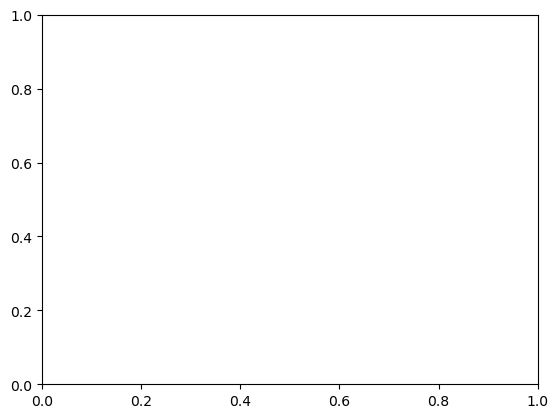

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, EPOCHS+1)

# Plot the training and validation loss values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot the training and validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# Print test metrics
print("Test Loss: {:.4f}".format(avg_test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test Precision: {:.4f}".format(test_precision))
print("Test Recall: {:.4f}".format(test_recall))



In [ ]:
# Create a confusion matrix for the test set
test_confusion = confusion_matrix(total_test_labels, total_test_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Create a confusion matrix for the test set
val_confusion = confusion_matrix(total_val_labels, total_val_predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
